In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from spn.structure.Base import Sum, Product, Context, get_nodes_by_type
from spn.structure.leaves.parametric.Parametric import Gaussian, Categorical
from spn.algorithms.LearningWrappers import learn_structure
from sklearn.datasets import make_classification
from spn.algorithms.MPE import mpe
from spn.algorithms.EM import EM_optimization
from spn.structure.leaves.piecewise.PiecewiseLinear import create_histogram_leaf
from spn.algorithms.splitting.RDC import get_split_cols_RDC_py
from spn.algorithms.splitting.Clustering import get_split_rows_KMeans
from sklearn.model_selection import train_test_split
from utils import random_region_graph, region_graph_to_spn, reassign_node_ids
from datasets.utils import get_vertical_train_data

In [56]:
def map_scopes(spn, inds):
    nodes = get_nodes_by_type(spn)
    scope_mapping = {i: s for i, s in enumerate(inds)}
    for n in nodes:
        sc = list(n.scope)
        new_sc = [scope_mapping[i] for i in sc]
        n.scope = new_sc
    return spn

def reassign_ids(spn):
    nodes = get_nodes_by_type(spn)
    for i, n in enumerate(nodes):
        n.id = i
    return spn

def make_dataset(num_samples, num_features, n_informative, n_redundant, n_classes, n_clusters, n_repeated):
    x, y = make_classification(num_samples, num_features, n_informative=n_informative, 
                               n_redundant=n_redundant, n_classes=n_classes, n_clusters_per_class=n_clusters,
                               n_repeated=n_repeated)
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3)
    train_data = np.hstack([train_x, train_y.reshape(-1, 1)])
    test_data = np.hstack([test_x, test_y.reshape(-1, 1)])
    return train_data, test_data

split_cols = get_split_cols_RDC_py(0.3, False)
split_rows = get_split_rows_KMeans(2, standardize=False)

In [2]:
data, subspaces = get_vertical_train_data('income', 4)

/home/jonas/dev/federated-learning/federated-spn/src/network-aligned-spn/datasets/datasets.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_data[col][self.train_data[col] >= percentiles] = percentiles
/home/jonas/dev/federated-learning/federated-spn/src/network-aligned-spn/datasets/datasets.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_data[col][self.test_data[col] >= percentiles] = percentiles
/home/jonas/dev/federated-learning/federated-spn/src/network-aligned-spn/datasets/datasets.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

In [ ]:
# take a RAT SPN for each client
# build a new RAT SPN structure over it
# train -> this is full

# take RAT SPN for each client
# train each client
# train RAT on top -> this is 2-step

In [53]:
num_features = 20
datasets = {}
for num_corrs in np.arange(0, 18, 2):
    inf = num_features - num_corrs
    train, test = make_dataset(2000, num_features, inf, num_corrs, 2, 1, 0)
    datasets[num_corrs] = (train, test)

In [44]:
num_features = 20

def train_fedspn_e2e(n_clients, spn_type='rat'):
    accs = []
    stds = []
    for r in np.arange(0, 18, 2):
        train_data, test_data = datasets[r]
        train_data = np.copy(train_data)
        test_data = np.copy(test_data)
        y = np.copy(test_data[:, -1])
        test_data[:, -1] = np.nan
        # split data on n clients vertically
        indices = np.arange(train_data.shape[1])
        s = np.array_split(indices, n_clients)
        class_idx = train_data.shape[1] - 1
        exp_accs = []
        for _ in range(10):
            # train one spn on each client
            spns = []
            for cl_idx in s:
                client_data = train_data[:, cl_idx]
                client_features = client_data.shape[1] - 1
                if class_idx in cl_idx:
                    context = Context(parametric_types=[Gaussian]*client_features + [Categorical]).add_domains(client_data)
                else:
                    context = Context(parametric_types=[Gaussian]*(client_features + 1)).add_domains(client_data)
                spn = learn_structure(client_data, context, split_rows, split_cols, create_histogram_leaf)
                sums = get_nodes_by_type(spn, Sum)
                for s in sums:
                    if s.weights is None or s.weights == []:
                        s.weights = [1/len(s.children)]*len(s.children)
                spns.append(spn)
            
            spn = Sum(weights=[1/(n_clients + 1)]*(n_clients + 1))
            scope = list(set().union(*[set(n.scope) for n in spns]))
            spn.scope = scope
            prods = []
            for _ in range(n_clients+1):
                p = Product(children=spns)
                p.scope = scope
                prods.append(p)
            spn.children = prods
            spn = reassign_ids(spn)
            EM_optimization(spn, train_data)

            # evaluate server model
            pred = mpe(spn, test_data)
            pred = pred[:, -1]
            acc = sum(y == pred) / len(y)
            exp_accs.append(acc)
        accs.append(np.mean(exp_accs))
        stds.append(np.std(exp_accs))
    return accs, stds

In [45]:
num_features = 20

def train_fedspn_two_step(n_clients, spn_type='rat'):
    accs = []
    stds = []
    for r in np.arange(0, 18, 2):
        train_data, test_data = datasets[r]
        train_data = np.copy(train_data)
        test_data = np.copy(test_data)
        y = np.copy(test_data[:, -1])
        test_data[:, -1] = np.nan
        # split data on n clients vertically
        indices = np.arange(train_data.shape[1])
        s = np.array_split(indices, n_clients)
        class_idx = train_data.shape[1] - 1
        exp_accs = []
        for _ in range(10):
            # train one spn on each client
            spns = []
            for cl_idx in s:
                client_data = train_data[:, cl_idx]
                client_features = client_data.shape[1] - 1
                if class_idx in cl_idx:
                    context = Context(parametric_types=[Gaussian]*client_features + [Categorical]).add_domains(client_data)
                else:
                    context = Context(parametric_types=[Gaussian]*(client_features + 1)).add_domains(client_data)
                spn = learn_structure(client_data, context, split_rows, split_cols, create_histogram_leaf)
                sums = get_nodes_by_type(spn, Sum)
                for s in sums:
                    if s.weights is None or s.weights == []:
                        s.weights = [1/len(s.children)]*len(s.children)
                EM_optimization(spn, client_data)
                spns.append(spn)
            
            spn = Sum(weights=[1/(n_clients + 1)]*(n_clients + 1))
            scope = list(set().union(*[set(n.scope) for n in spns]))
            spn.scope = scope
            prods = []
            for _ in range(n_clients+1):
                p = Product(children=spns)
                p.scope = scope
                prods.append(p)
            spn.children = prods
            spn = reassign_ids(spn)

            # optimize server SPN
            # NOTE: It's legal to put client data in here since we can propagate likelihoods
            #   over the network without sending private information
            EM_optimization(spn, train_data)

            # evaluate server model
            pred = mpe(spn, test_data)
            pred = pred[:, -1]
            acc = sum(y == pred) / len(y)
            exp_accs.append(acc)
        accs.append(np.mean(exp_accs))
        stds.append(np.std(exp_accs))
    return accs, stds

In [46]:
num_clients = [2, 3, 4, 5]
accs_e2e = []
stds_e2e = []
for c in num_clients:
    accs_e2e_c, stds_e2e_c = train_fedspn_e2e(c)
    accs_e2e.append(accs_e2e_c)
    stds_e2e.append(stds_e2e_c)

In [47]:
accs_2step = []
stds_2step = []
for c in num_clients:
    accs_2step_c, stds_2step_c = train_fedspn_two_step(c)
    accs_2step.append(accs_2step_c)
    stds_2step.append(stds_2step_c)

In [48]:
accs_e2e

[[0.5233333333333333,
  0.5266666666666666,
  0.5233333333333333,
  0.4966666666666667,
  0.48666666666666664,
  0.51,
  0.5166666666666667,
  0.5083333333333332,
  0.5216666666666666],
 [0.5233333333333333,
  0.5266666666666666,
  0.5233333333333333,
  0.4966666666666667,
  0.48666666666666664,
  0.51,
  0.5166666666666667,
  0.5083333333333332,
  0.5216666666666666],
 [0.5233333333333333,
  0.5266666666666666,
  0.5233333333333333,
  0.4966666666666667,
  0.48666666666666664,
  0.51,
  0.5166666666666667,
  0.5083333333333332,
  0.5216666666666666],
 [0.5233333333333333,
  0.5266666666666666,
  0.5233333333333333,
  0.4966666666666667,
  0.48666666666666664,
  0.51,
  0.5166666666666667,
  0.5083333333333332,
  0.5216666666666666]]

In [49]:
accs_2step

[[0.5233333333333333,
  0.5266666666666666,
  0.5233333333333333,
  0.4966666666666667,
  0.48666666666666664,
  0.51,
  0.5166666666666667,
  0.5083333333333332,
  0.5216666666666666],
 [0.5233333333333333,
  0.5266666666666666,
  0.5233333333333333,
  0.4966666666666667,
  0.48666666666666664,
  0.51,
  0.5166666666666667,
  0.5083333333333332,
  0.5216666666666666],
 [0.5233333333333333,
  0.5266666666666666,
  0.5233333333333333,
  0.4966666666666667,
  0.48666666666666664,
  0.51,
  0.5166666666666667,
  0.5083333333333332,
  0.5216666666666666],
 [0.5233333333333333,
  0.5266666666666666,
  0.5233333333333333,
  0.4966666666666667,
  0.48666666666666664,
  0.51,
  0.5166666666666667,
  0.5083333333333332,
  0.5216666666666666]]

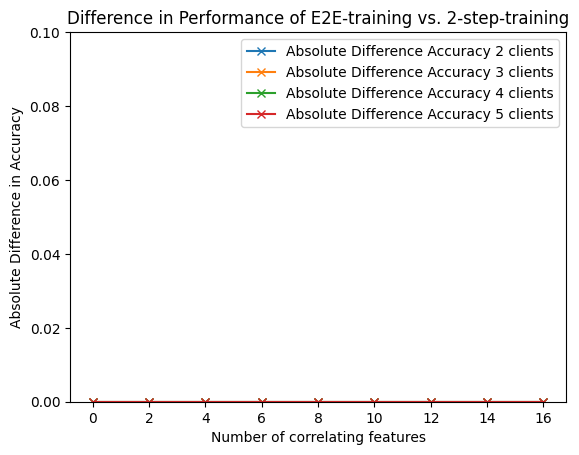

In [50]:
fig = plt.figure()
for idx, num_c in enumerate(num_clients):
    accs_e2e_c = np.array(accs_e2e[idx])
    accs_two_step_c = np.array(accs_2step[idx])
    diff = abs(accs_two_step_c - accs_e2e_c)
    x = np.arange(len(accs_e2e_c))
    plt.plot(x, diff, label=f'Absolute Difference Accuracy {num_c} clients', marker='x')
plt.xticks(np.arange(len(accs_e2e[0])), np.arange(0, len(accs_e2e[0])*2, 2))
plt.xlabel('Number of correlating features')
plt.ylabel('Absolute Difference in Accuracy')
plt.ylim([0., 0.1])
plt.title('Difference in Performance of E2E-training vs. 2-step-training')
plt.legend()
plt.show()